In [1]:
import pandas as pd
import numpy as np
import os 
import rfcode.helpfunctions as hf
from sklearn import decomposition
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectPercentile
import matplotlib.pyplot as plt
import nibabel
from IPython import display

# iPython specific
%matplotlib inline

In [3]:
dirname='/vol/medic01/users/ecr05/for_ricardo/' 
subjectpath='/vol/medic01/users/ecr05/HCP_PARCELLATION/TRAININGDATA/TRAININGandVALlist.txt'
csvpath='unrestricted.csv' # behavioural spreadsheet
datapath='/vol/medic01/users/ecr05/HCP_PARCELLATION/TESTINGDATA/rfTrainData.npy' # data converted into nxm feature matrix
test_datapath='/vol/medic01/users/ecr05/HCP_PARCELLATION/TESTINGDATA/rfTestData.npy'

variable='PMAT24_A_CR' # dependent variable
RANDOM_STATE =42
readtype='HCP_avfeatures'
# set random forest with parameters that have been optimised through 10 fold cross validation
nTrees=1000 
tDepth=9
maxf=75

trainingDATA=hf.read_DATA(datapath,readtype) # read train data
testDATA=hf.read_DATA(test_datapath,readtype) # read test data
xl_file = pd.read_csv(os.path.join(dirname,csvpath)) # read behavioural variable spreadsheet 
subjects=hf.get_subjects(trainingDATA,subjectpath,readtype) # get subjects list 

/vol/medic01/users/ecr05/HCP_PARCELLATION/TRAININGDATA/TRAININGandVALlist.txt


In [11]:
deletedrows=[]
labels = []  # SELECT labels for subset (in future could choose a few and loop over)
for index, subj in enumerate(subjects):
# print(index,subj)
    if (xl_file.loc[xl_file['Subject'] == int(subj), variable].shape != (0,)):
        # print(xl_file.loc[xl_file['Subject']==int(subj),variables[0]].item())
        labels.append(xl_file.loc[xl_file['Subject'] == int(subj), variable].item())

    else:
        # delete data for which there are no labels
        print('delete rows', index, subjects[index])
        deletedrows.append(index)

features_v=np.delete(trainingDATA, deletedrows, 0)
print('features_v shape',features_v.shape)
labels=np.asarray(labels)


delete rows 246 142626
features_v shape (419, 39600)


precentile 0.1
precentile 0.5
precentile 1
precentile 3
precentile 5
precentile 7
precentile 9
precentile 11
precentile 13
precentile 15
precentile 20
precentile 30
precentile 50
precentile 80
precentile 100
The optimal threshold percentile 0.5
[0.17939888750915967, 0.21107371766565489, 0.20560206589970445, 0.19664179625571476, 0.17151242692915811, 0.15956263087774955, 0.14348016961754229, 0.12322657308803693, 0.089433863526329829, 0.082804842882765836, 0.049616749981724162, -0.069616905113567926, -0.18614185382721624, -0.29199817526526939, -0.37288295883594474]


/vol/medic01/users/ecr05/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:21: VisibleDeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future


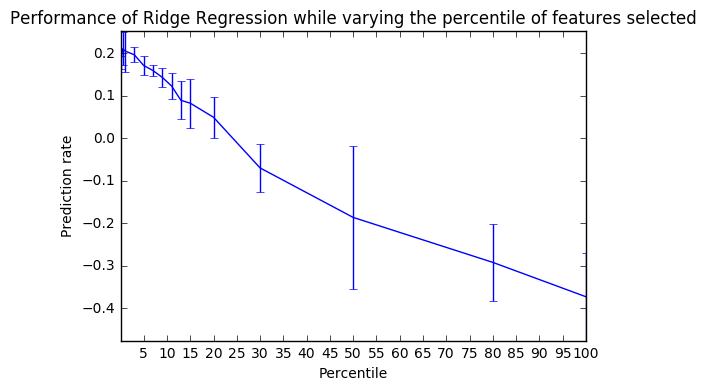

In [15]:
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn import linear_model
from sklearn.feature_selection import f_regression
#from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
transform = SelectPercentile(score_func=f_regression)

clf = Pipeline([('anova', transform), ('ridge', linear_model.Ridge(alpha=10.0))])
score_means = list()
score_stds = list()
percentiles = (0.1, 0.5,1,3, 5, 7,9, 11,13, 15, 20, 30, 50, 80, 100)

for percentile in percentiles:
    print('precentile',percentile)
    clf.set_params(anova__percentile=percentile)
    # Compute cross-validation score using 1 CPU
    this_scores = cross_val_score(clf, features_v, labels, n_jobs=1)
    score_means.append(this_scores.mean())
    score_stds.append(this_scores.std())

optimal_threshold=percentiles[np.where(score_means==np.max(score_means))[0]]



print('The optimal threshold percentile', optimal_threshold)
print(score_means)

# Plot the distribution
plt.errorbar(percentiles, score_means, np.array(score_stds))

plt.title(
    'Performance of Ridge Regression while varying the percentile of features selected')
plt.xlabel('Percentile')
plt.ylabel('Prediction rate')
plt.xticks(np.arange(0, max(percentiles)+1, 5))
plt.axis('tight')
plt.show()

In [16]:
kbest=SelectPercentile(score_func=f_regression,percentile=optimal_threshold)
featuresbest = kbest.fit_transform(features_v, labels)
f_mask=kbest.get_support() # mask of features used
indices1=np.where(f_mask==True)
print(np.max(kbest.pvalues_[indices1]))

0.000123809507275


after anova testing number of features is  198


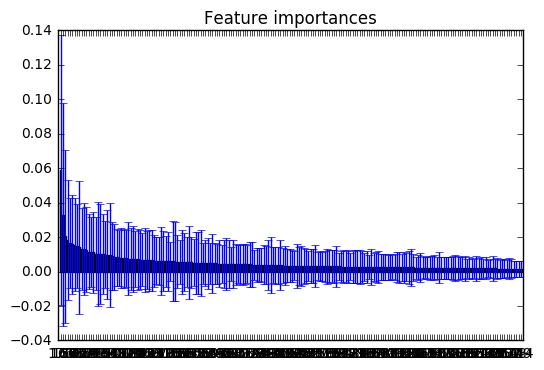

In [17]:
model=RandomForestRegressor(n_estimators=1000,random_state=RANDOM_STATE,n_jobs=-1)
model.fit(featuresbest,labels)
importances=model.feature_importances_
print('after anova testing number of features is ', featuresbest.shape[1])
std = np.std([tree.feature_importances_ for tree in model.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

plt.figure()
plt.title("Feature importances")
plt.bar(range(featuresbest.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(featuresbest.shape[1]), indices)
plt.xlim([-1, featuresbest.shape[1]])
plt.show()

5
10
15
25
50
75
100
150
198
optimal threshold according to linear svm 50 0.376762709141


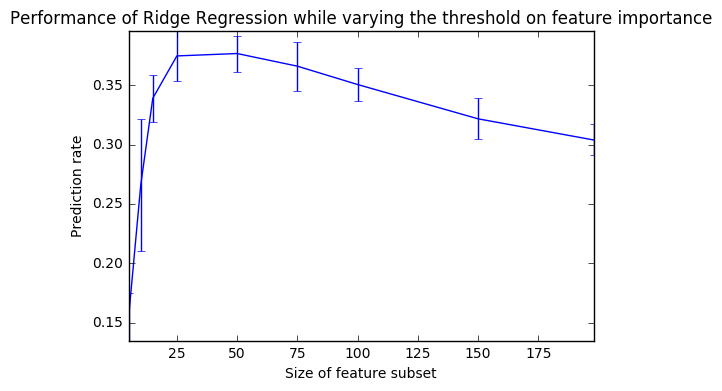

[  100.   350.   600.   850.  1100.  1350.  1600.  1850.]


In [22]:
thresholds = (5,10,15,25,50, 75, 100, 150,featuresbest.shape[1])
clf=RandomForestRegressor(n_estimators=1000,random_state=RANDOM_STATE,n_jobs=-1) #linear_model.Ridge(alpha=10.0) 
score_means=[]
score_stds=[]
for threshold in thresholds:
    print(threshold)
    featuresfin=featuresbest[:,indices[:threshold]]
    
   
    # Compute cross-validation score using 1 CPU
    this_scores = cross_val_score(clf, featuresfin, labels, n_jobs=1)
    score_means.append(this_scores.mean())
    score_stds.append(this_scores.std())

optimal_threshold=thresholds[np.where(score_means==np.max(score_means))[0][0]]
print('optimal threshold according to linear svm',optimal_threshold, np.max(score_means))

# Plot the distribution
plt.errorbar(thresholds, score_means, np.array(score_stds))

plt.title(
    'Performance of Ridge Regression while varying the threshold on feature importance')
plt.xlabel('Size of feature subset')
plt.ylabel('Prediction rate')
plt.xticks(np.arange(0,200,25))
plt.axis('tight')
plt.show()
print(np.arange(100.0,2000.0,250))